In [ ]:
!git clone -q https://github.com/marius311/muse-wl/
!pip install --upgrade "poetry==1.2.0b2"
!(cd muse-wl && POETRY_VIRTUALENVS_IN_PROJECT=true poetry install)
import sys, os.path as osp
sys.path = [osp.abspath("muse-wl/.venv/lib/python3.7/site-packages")] + sys.path

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches': 'tight', 'dpi': 90}

In [3]:
import jax
import jax.numpy as jnp
import muse_inference
from muse_inference.jax import JaxMuseProblem
from muse_inference import MuseResult
import jax_cosmo as jc

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

import powerbox_jax as pbj
import haiku as hk
master_seed = hk.PRNGSequence(42)

/global/u1/m/marius/.cache/pypoetry/virtualenvs/muse-wl-eWVKUzZZ-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/u1/m/marius/.cache/pypoetry/virtualenvs/muse-wl-eWVKUzZZ-py3.9/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/global/u1/m/marius/.cache/pypoetry/virtualenvs/muse-wl-eWVKUzZZ-py3.9/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


Check using expected device:

In [4]:
from jax.lib import xla_bridge
xla_bridge.get_backend().platform

'gpu'

# Defining a model

In [95]:
def make_power_map(pk_fn, N, field_size, zero_freq_val=0.0):
    k = 2*jnp.pi*jnp.fft.fftfreq(N, d=field_size / N)
    kcoords = jnp.meshgrid(k,k)
    k = jnp.sqrt(kcoords[0]**2 + kcoords[1]**2)
    ps_map = pk_fn(k)
    ps_map = ps_map.at[0,0].set(zero_freq_val)
    return ps_map * (N / field_size)**2

def model(N=64,                # number of pixels on the map
          map_size=10,         # map size in deg.
          gal_per_arcmin2=30,   
          sigma_e=0.2):      
    
    pix_area = (map_size * 60 / N)**2 # arcmin2 
    map_size = map_size / 180 * jnp.pi    # radians

    # Sampling cosmology
    omega_c = numpyro.sample('omega_c', dist.Normal(0., 1.0)) * 0.05 + 0.3
    sigma_8 = numpyro.sample('sigma_8', dist.Normal(0., 1.0)) * 0.05 + 0.8
    
    cosmo = jc.Planck15(Omega_c=omega_c, sigma8=sigma_8)
    # Creating a given redshift distribution
    pz = jc.redshift.smail_nz(0.5, 2., 1.0)
    tracer = jc.probes.WeakLensing([pz])
    
    # Defining the function that will compute the power spectrum of the field
    # Create an interpolation array for the cls to avoid far too many computations
    ell_tab = jnp.logspace(0, 4.5, 128)
    cell_tab = jc.angular_cl.angular_cl(cosmo, ell_tab, [tracer])[0]
    P = lambda k: jc.scipy.interpolate.interp(k.flatten(), ell_tab, cell_tab).reshape(k.shape)
    # Sampling latent variables
    z = numpyro.sample('z', dist.Independent(dist.Normal(jnp.zeros((N,N)), 1), 2))
    # Convolving by the power spectrum
    field = jnp.fft.ifft2(jnp.fft.fft2(z) * 
                          jnp.sqrt(make_power_map(P, N, map_size))).real
    
    # Adding "observational noise"
    x = numpyro.sample('x', dist.Independent(dist.Normal(field, sigma_e/jnp.sqrt(gal_per_arcmin2 * pix_area)), 2))
    
    return x

In [96]:
# Create our fiducial observations
fiducial_model = condition(model, {'omega_c': 0., 'sigma_8': 0.})
sample_map_fiducial = seed(fiducial_model, jax.random.PRNGKey(42))
m_data = sample_map_fiducial()

/global/u1/m/marius/.cache/pypoetry/virtualenvs/muse-wl-eWVKUzZZ-py3.9/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:6690: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [99]:
@jax.jit
def log_likelihood(x, z, theta):
    oc = theta[0]
    s8 = theta[1]

    cond_model = condition(model, {'omega_c': oc, 'sigma_8': s8, 'x': x, 
                                 'z': z})
    model_trace = trace(cond_model).get_trace()

    return (
        model_trace['x']['fn'].log_prob(model_trace['x']['value']) + 
        model_trace['z']['fn'].log_prob(model_trace['z']['value'])
    )

@jax.jit
def log_prior(theta):
    oc = theta[0]
    s8 = theta[1]
    log_prob = dist.Normal(0., 1.).log_prob(oc) + dist.Normal(0., 1.).log_prob(s8) 
    return log_prob

@jax.jit 
def sample(theta, key):
    oc = theta[0]
    s8 = theta[1]
    cond_model = condition(seed(model, key), {'omega_c': oc, 'sigma_8': s8})
    model_trace = trace(cond_model).get_trace()
    return model_trace['x']['value'], model_trace['z']['value']

In [100]:
class LensingProblem(JaxMuseProblem):

    def sample_x_z(self, rng, θ):
        return sample(jnp.array(θ), rng)

    def logLike(self, x, z, θ):
        return log_likelihood(x, z, jnp.array(θ))

    def logPrior(self, θ):
        return log_prior(θ)

In [101]:
θ_true = 0., 0.

In [141]:
prob = LensingProblem(implicit_diff=False)
(x, z) = prob.sample_x_z(jax.random.PRNGKey(0), θ_true)
prob.set_data(x)

# Sanity check

Note: if I decrease to `z_tol=1e-2` or lower, I get a `history.status=4` which means saddle point?? Is this multi-modal? Or perhaps an issue with the phase being periodic?

In [142]:
MAP = prob.z_MAP_and_score(x, z, θ_true, z_tol=1e-2)

In [143]:
MAP.history.success

DeviceArray(True, dtype=bool)

In [144]:
MAP.history.status

DeviceArray(0, dtype=int32, weak_type=True)

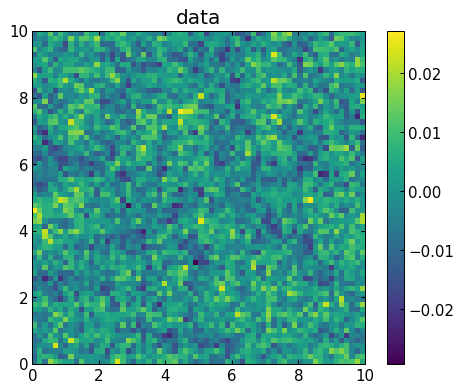

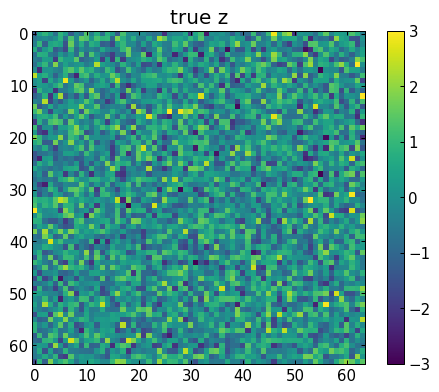

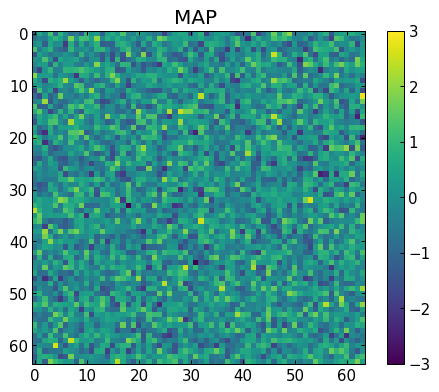

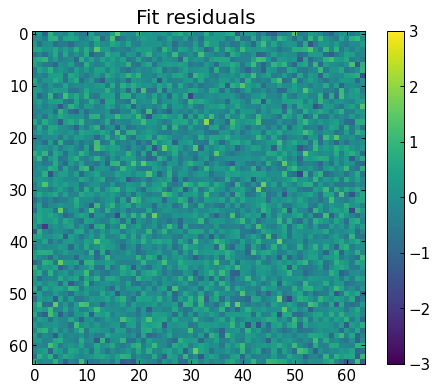

In [145]:
figure(); imshow(x, extent=(0,10,0,10)); colorbar()
title("data")
figure(); imshow(z,vmin=-3, vmax=3); colorbar()
title("true z")
figure(); imshow(MAP.z,vmin=-3, vmax=3); colorbar()
title("MAP ")
figure(); imshow(MAP.z - z,vmin=-3, vmax=3); colorbar()
title("Fit residuals "); 

# Get covariance

Compute the covariance evaluated at the truth, which involves getting the $J$ and $H$ matrices.

In [146]:
result = MuseResult()
result.θ = θ_true;

In [147]:
prob.get_J(
    result, 
    nsims = 100, 
    progress = True, 
    z_tol = 1e-2, 
    rng = jax.random.PRNGKey(0),
);



get_J:   0%|          | 0/100 [00:00<?, ?it/s]

get_J:   1%|          | 1/100 [01:18<2:08:59, 78.17s/it]

get_J:   2%|▏         | 2/100 [01:18<52:55, 32.40s/it]  

get_J:   3%|▎         | 3/100 [01:18<28:43, 17.77s/it]

get_J:   4%|▍         | 4/100 [01:19<17:26, 10.90s/it]

get_J:   5%|▌         | 5/100 [01:19<11:14,  7.10s/it]

get_J:   6%|▌         | 6/100 [01:19<07:31,  4.80s/it]

get_J:   7%|▋         | 7/100 [01:20<05:11,  3.35s/it]

get_J:   8%|▊         | 8/100 [01:20<03:40,  2.40s/it]

get_J:   9%|▉         | 9/100 [01:21<02:40,  1.76s/it]

get_J:  10%|█         | 10/100 [01:21<01:59,  1.33s/it]

get_J:  11%|█         | 11/100 [01:21<01:31,  1.03s/it]

get_J:  12%|█▏        | 12/100 [01:22<01:12,  1.21it/s]

get_J:  13%|█▎        | 13/100 [01:22<00:59,  1.46it/s]

get_J:  14%|█▍        | 14/100 [01:22<00:50,  1.69it/s]

get_J:  15%|█▌        | 15/100 [01:23<00:50,  1.68it/s]

get_J:  16%|█▌        | 16/100 [01:23<00:44,  1.89it/s]

get_J:  17%|█▋        | 17/100 [01:24<00:39

Score for sims vs. score for data, which should be contained within sim contours:

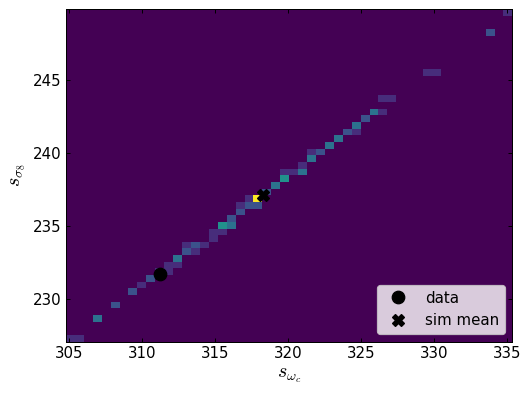

In [148]:
MAP = prob.z_MAP_and_score(prob.x, 0*z, θ_true, z_tol=1e-1);
hist2d(*transpose(result.s_MAP_sims), bins=50);
plot(*MAP.s, "ko", ms=10, label="data");
plot(*mean(result.s_MAP_sims, axis=0), "kX", ms=10, label="sim mean");
xlabel(r"$s_{\omega_c}$");
ylabel(r"$s_{\sigma_8}$");
legend(frameon=True, loc="lower right");

In [161]:
prob.get_H(
    result, 
    θ = θ_true, 
    step = 0.1, 
    nsims = 10, 
    progress = False, 
    z_tol = 1e-2, 
    rng = jax.random.PRNGKey(0)
);

Looks like very little extra constraint beyond the prior, is that expected for this small map maybe?:

In [164]:
result.H

DeviceArray([[50.123062, 37.34201 ],
             [38.59819 , 28.755579]], dtype=float32)

In [165]:
sqrt(diag(result.Σ))

array([0.5995182, 0.8028664], dtype=float32)

Just to visualize the correlation:

Text(0, 0.5, '$\\sigma_8$')

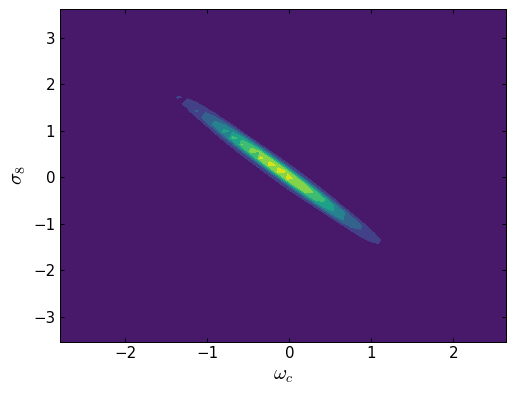

In [166]:
Z, X, Y = histogram2d(*result.dist.rvs(1000000).T, bins=50, density=True)
contourf((X[1:]+X[:-1])/2, (Y[1:]+Y[:-1])/2, Z)
xlabel(r"$\omega_c$")
ylabel(r"$\sigma_8$")

# Get estimate

Run the estimate. Not really finding convergence yet.

In [167]:
prob.solve(
    result = result, 
    α = 0.2, 
    θ_start = [0, 0], 
    θ_rtol = 0,
    z_tol = 1e-1, 
    progress = True, 
    maxsteps = 10, 
    nsims = 64,
    rng = jax.random.PRNGKey(1)
);



MUSE:   0%|          | 0/650 [00:00<?, ?it/s]

MUSE:   0%|          | 1/650 [00:00<03:03,  3.53it/s]

MUSE:   0%|          | 2/650 [00:00<03:05,  3.49it/s]

MUSE:   0%|          | 3/650 [00:00<02:59,  3.61it/s]

MUSE:   1%|          | 4/650 [00:01<02:56,  3.66it/s]

MUSE:   1%|          | 5/650 [00:01<02:55,  3.68it/s]

MUSE:   1%|          | 6/650 [00:01<02:55,  3.67it/s]

MUSE:   1%|          | 7/650 [00:01<02:55,  3.67it/s]

MUSE:   1%|          | 8/650 [00:02<03:00,  3.56it/s]

MUSE:   1%|▏         | 9/650 [00:02<02:56,  3.63it/s]

MUSE:   2%|▏         | 10/650 [00:02<02:55,  3.64it/s]

MUSE:   2%|▏         | 11/650 [00:03<02:57,  3.61it/s]

MUSE:   2%|▏         | 12/650 [00:03<02:58,  3.57it/s]

MUSE:   2%|▏         | 13/650 [00:03<02:57,  3.59it/s]

MUSE:   2%|▏         | 14/650 [00:03<03:01,  3.50it/s]

MUSE:   2%|▏         | 15/650 [00:04<03:04,  3.44it/s]

MUSE:   2%|▏         | 16/650 [00:04<03:01,  3.49it/s]

MUSE:   3%|▎         | 17/650 [00:04<02:54,  3.62it/s]

MUSE:   

The norm of the MUSE marginal score approximation, i.e. the thing we're trying to zero. This should hopefully descrease until it reaches zero within some tolerance.

(0.0, 8.547867646813392)

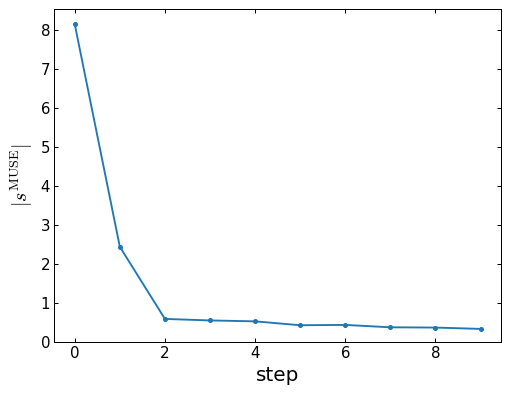

In [168]:
plot([norm(h["s̃_post"]) for h in result.history],".-")
ylabel(r"$|s^{\rm MUSE}|$")
xlabel("step")
ylim(0)

Internal rough estimate of $\sigma(\theta)$ (given by diagonal of the $J^{-1}$ matrix) used inside the solver to determine step-size:

Text(0.5, 0, 'step')

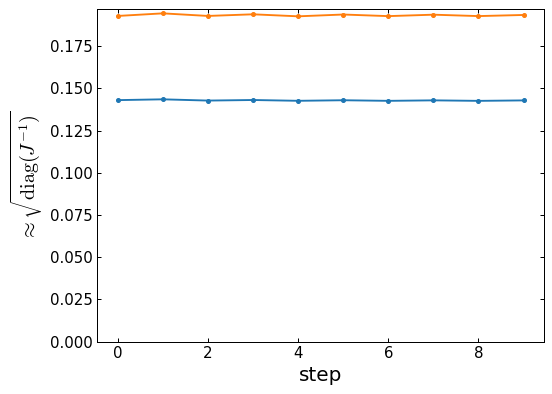

In [170]:
plot([np.sqrt(-np.diag(h["H̃_inv_like_sims"])) for h in result.history],".-")
ylim(0)
ylabel(r"$\approx \sqrt{{\rm diag}(J^{-1})}$")
xlabel("step")

Progression of $\theta$ across steps. Should see this converge to somewhere.


Text(0, 0.5, '$\\sigma_8$')

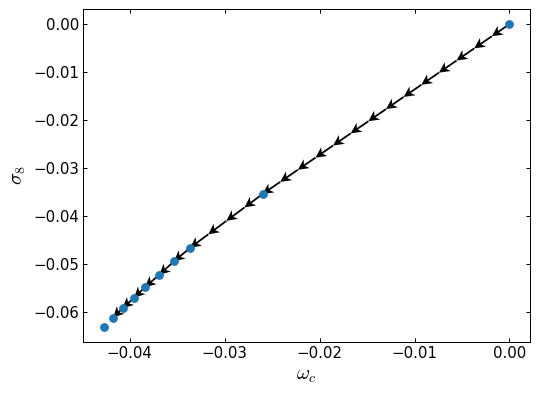

In [169]:
# https://stackoverflow.com/a/66117937
x,y = transpose([h["θ"] for h in result.history])
plt.plot(x,y,"o")
ds = 0.003
Ns = np.round(np.sqrt( (x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2 ) / ds).astype(int)
subdiv = lambda x, Ns=Ns: np.concatenate([ np.linspace(x[ii], x[ii+1], Ns[ii]) for ii, _ in enumerate(x[:-1]) ])
x, y = subdiv(x), subdiv(y)
plt.quiver(x[:-1], y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], scale_units='xy', angles='xy', scale=1, width=.004, headlength=6, headwidth=6)
xlabel(r"$\omega_c$")
ylabel(r"$\sigma_8$")